# Pipeline simulation

We begin by simulating a forward pass through the network. This helps us inspect the outputs at each stage, making it easier to debug and validate our hardware implementation.

To do this, we first load the model weights and image data. Then, we run the forward pass and print the intermediate results after each layer.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
np.random.seed(42)

In [2]:
def load_matrix_from_mif(filename, shape):
    # Initialize an empty list to store the values
    values = []

    # Open and read the .mif file
    with open(filename, 'r') as mif_file:
        for line in mif_file:
            hex_value = line.strip()

            # Convert the hex string to a 32-bit unsigned integer
            unsigned_val = int(hex_value, 16)

            # Convert to a signed 32-bit integer using two's complement
            if unsigned_val >= 0x80000000:
                signed_val = unsigned_val - 0x100000000
            else:
                signed_val = unsigned_val

            # Append to the list of values
            values.append(signed_val)

    # Reshape the values list into the specified matrix shape
    matrix = np.array(values).reshape(shape)

    return matrix


In [3]:
def load_image_from_mif(file_path):
    with open(file_path, 'r') as file:
        # Read all lines, strip newlines, and convert each hex string to an int
        data = [int(line.strip(), 16) for line in file.readlines()]

    # Convert to a NumPy array and reshape to 1x784 (flattened 28x28 image)
    x = np.array(data, dtype=np.int64).reshape(1, 784)
    return x

In [4]:
def visualize_digit(tensor):
    digit_image = tensor.reshape(28, 28)

    # Set the figure size (increase width and height as needed)
    plt.figure(figsize=(6, 6))  # Example: Make the image 6x6 inches

    plt.imshow(digit_image, cmap='gray')

    # Add coordinates (ticks) for x and y axes
    plt.axis('on')  # Turn on the axes
    plt.xticks(range(0, 28, 1))  # x-axis ticks every 1 pixel
    plt.yticks(range(0, 28, 1))  # y-axis ticks every 1 pixel

    plt.show()

In [5]:
# Upload wieghts and test image
from google.colab import files
uploaded = files.upload()

# Define the expected matrix dimensions
dims = {
    'weights1': (784, 64),
    'weights2': (64, 64),
    'weights3': (64, 32),
    'weights4': (32, 10)
}

# Load all matrices from .mif files
matrices = {}
for name, shape in dims.items():
    filename = f'{name}.mif'
    matrices[name] = load_matrix_from_mif(filename, shape)

# Print shapes to verify
for name, matrix in matrices.items():
    print(f"{name} shape: {matrix.shape}")
    print(matrix)

Saving image_0.mif to image_0.mif
Saving image_1.mif to image_1.mif
Saving weights1.mif to weights1.mif
Saving weights2.mif to weights2.mif
Saving weights3.mif to weights3.mif
Saving weights4.mif to weights4.mif
weights1 shape: (784, 64)
[[ -5  -5 -10 ... -10  -3   3]
 [ -3  -5   0 ...   5   0  -3]
 [  0 -10   0 ...   5   3   0]
 ...
 [  3  -3  10 ...  -8 -10  -3]
 [  0  -3   0 ...   0  10  10]
 [ -3 -15   5 ...  -3   3   3]]
weights2 shape: (64, 64)
[[  0 -10   5 ... -19   5  -5]
 [-15   0 -15 ... -15 -15   0]
 [  0  -5 -15 ... -10   0 -10]
 ...
 [ 15 -10  -5 ...  -5   0   0]
 [-10   3  17 ...  15  26   5]
 [-15  -2   0 ...  -5  20  -5]]
weights3 shape: (64, 32)
[[  5 -14  -5 ... -14  -5 -14]
 [  0  10  -9 ...  15  17   5]
 [ -9   5  25 ...  10   5   5]
 ...
 [  0   0   0 ...   5  10  -5]
 [  2   0   0 ...  10  15  -5]
 [ 10   3   4 ...   0   5  -9]]
weights4 shape: (32, 10)
[[  0  19  -5  -2 -29   0 -29  -5   4 -15]
 [  5 -15   1   0  -9   0  14 -14  -4  19]
 [ -4   8  -2   5 -15 -17

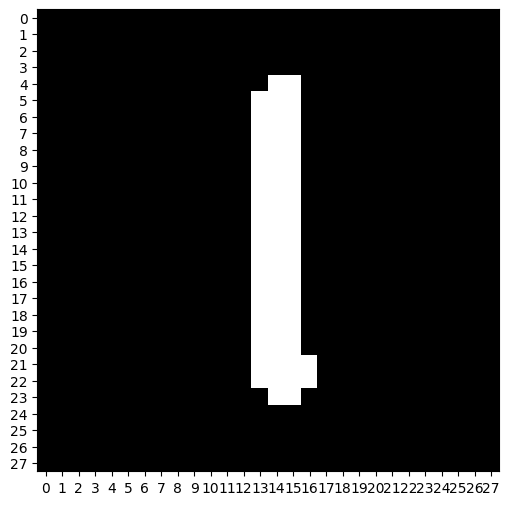

Input shape: (1, 784)
After Layer 1 and Relu 1 (x1) shape: (1, 64)
[[ 27  36 148  36   0   0   0  49  95   0   0   0   0   0   0  67   0   0
   46   0   0  61  54  46   0   0   0   0   0   0 172  26  58   0   0   8
   18  14  77 133 101  69   0  91  93   0  47   0  58  84  29  38   0   0
  104   8   7   0  37   0   0   1   0   0]]
After Layer 2 and Relu 2 (x2) shape: (1, 64)
[[ 3023     0     0  8113  5191  3364     0     0  1556  4496  5385  8106
   9036  1736  1436  4824     0     0  1392  3838     0 10394  1880 15332
   5886   856     0  2907  3309     0  2666 10528     0   162   524     0
    384     0     0  4924     0  4093 10192  7921     0   398  3648  4364
      0  4640  9240   873     0     0     0     0  1155  1208  7651     0
      0     0     0     0]]
After Layer 3 (x3) and Relu 3 shape: (1, 32)
[[ 845617       0       0       0  513904  605684  403153       0       0
   688262 1051995  307696       0       0  190133       0  899773       0
  1092251  213210  492064   499

In [6]:
x = load_image_from_mif('image_1.mif') # Rename file here according to uploaded image

# Visualize the input tensor
visualize_digit(x)

# Neural network pipeline
print(f"Input shape: {x.shape}")

# Layer 1: (1,784) @ (784,64) -> (1,64)
x1 = x @ matrices['weights1']
x1 = np.maximum(0, x1)  # ReLU
print(f"After Layer 1 and Relu 1 (x1) shape: {x1.shape}")
print(x1)

# Layer 2: (1,64) @ (64,64) -> (1,64)
x2 = x1 @ matrices['weights2']
x2 = np.maximum(0, x2)  # ReLU
print(f"After Layer 2 and Relu 2 (x2) shape: {x2.shape}")
print(x2)

# Layer 3: (1,64) @ (64,32) -> (1,32)
x3 = x2 @ matrices['weights3']
x3 = np.maximum(0, x3)  # ReLU
print(f"After Layer 3 (x3) and Relu 3 shape: {x3.shape}")
print(x3)

# Layer 4: (1,32) @ (32,10) -> (1,10)
x4 = x3 @ matrices['weights4']
print(f"After Layer 4 (x4) shape: {x4.shape}")
print(x4)

# Output logits
output = x4
print("\nOutput logits:")
print(output)

# Predicted class
predicted_class = np.argmax(output)
print("\nPredicted class:", predicted_class)

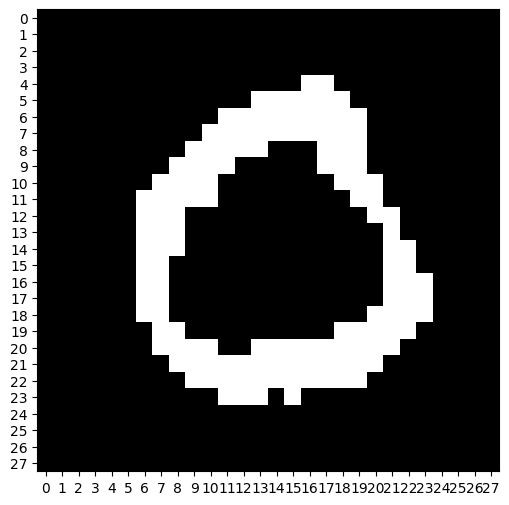

Input shape: (1, 784)
After Layer 1 and Relu 1 (x1) shape: (1, 64)
[[  6 130 206  29 116   0   0 349 241   0   0 178 188   0  67 224  90  80
    0 168  57   0   0  69 112   0   0  83   0   0 226  31  31   0   0   0
  107 127   0 262   0  86 131 235  12 251 160  12  83  23  50   0   0   0
    0  64   0  86 170   0   0 103   0 110]]
After Layer 2 and Relu 2 (x2) shape: (1, 64)
[[    0     0     0 11819 12808  6491     0     0     0     0  3186 19703
   5061     0  8070 10004     0     0  2680  6046     0 11992  2900 18895
  12999     0     0  2465     0     0  4809     0  4336 10814     0  1723
   4055     0   153   963  1601  7761 25546 11204     0  7841  1020  4570
   4117     0 25423    74  1293     0  7257     0     0     0 15202 13711
   8985     0     0  1307]]
After Layer 3 (x3) and Relu 3 shape: (1, 32)
[[1448449       0       0  266188 1434774  576601  684904   81880       0
  1554074 2173165  688808       0       0  798151       0 2225117       0
  1694048       0 1381078  1344

In [7]:
x = load_image_from_mif('image_0.mif') # Rename file here according to uploaded image

# Visualize the input tensor
visualize_digit(x)

# Neural network pipeline
print(f"Input shape: {x.shape}")

# Layer 1: (1,784) @ (784,64) -> (1,64)
x1 = x @ matrices['weights1']
x1 = np.maximum(0, x1)  # ReLU
print(f"After Layer 1 and Relu 1 (x1) shape: {x1.shape}")
print(x1)

# Layer 2: (1,64) @ (64,64) -> (1,64)
x2 = x1 @ matrices['weights2']
x2 = np.maximum(0, x2)  # ReLU
print(f"After Layer 2 and Relu 2 (x2) shape: {x2.shape}")
print(x2)

# Layer 3: (1,64) @ (64,32) -> (1,32)
x3 = x2 @ matrices['weights3']
x3 = np.maximum(0, x3)  # ReLU
print(f"After Layer 3 (x3) and Relu 3 shape: {x3.shape}")
print(x3)

# Layer 4: (1,32) @ (32,10) -> (1,10)
x4 = x3 @ matrices['weights4']
print(f"After Layer 4 (x4) shape: {x4.shape}")
print(x4)

# Output logits
output = x4
print("\nOutput logits:")
print(output)

# Predicted class
predicted_class = np.argmax(output)
print("\nPredicted class:", predicted_class)

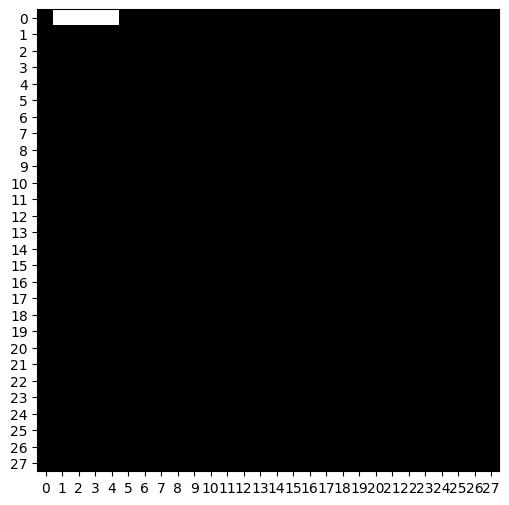

 - - - - - - - - - - - - - - - - - - - - 
Input shape: (1, 784)
After Layer 1 and Relu 1 (x1) shape: (1, 64)
[[ 5  0  0 20  0 11  0 17  0 21 10  0  0 13  0 15 12  0  0  0  0  0  0  5
   7  0 15  0  0  0  0  4  0  0  0  0  0  5  0 21  0 19  7  0 17 22 15  0
   0  8  0  0 10 10 13  0  5 27  0  2 21 15  8  2]]
After Layer 2 and Relu 2 (x2) shape: (1, 64)
[[ 325 1669    0  958 1345 1728  652  176    0  758 1322 1085  610 1278
   112 1361    0  460  266 1610  837  117  872 1279  930    0  461  600
     0  322 1170    0  867  518    0    0 1092    0  969    0  521  468
  2514  245  365  321  537 2276  241    0 1819  118  238    0    0    0
   695   60 1378  749 2867  688  566  899]]
After Layer 3 (x3) and Relu 3 shape: (1, 32)
[[165972      0      0  37917 168243  11062 183219      0      0 171261
  304187 167634  34491    410 184791   9716 237722      0 300316  12637
   99551  50152 130087  90474 155478  44116      0  75788  65214 125291
  156286      0]]
After Layer 4 (x4) shape: (1, 10)
[

In [8]:
# Initialize input tensor with the first pixel as 1 and the rest as 0
x = np.zeros((1, 784), dtype=np.int64)
x[0, 1] = 1  # Set the first pixel to 1
x[0, 2] = 1  # Set the first pixel to 1
x[0, 3] = 1  # Set the first pixel to 1
x[0, 4] = 1  # Set the first pixel to 1

# Visualize the input tensor
visualize_digit(x)

print(" - - - - - - - - - - - - - - - - - - - - ")
# Neural network pipeline
print(f"Input shape: {x.shape}")

# Layer 1: (1,784) @ (784,64) -> (1,64)
x1 = x @ matrices['weights1']
x1 = np.maximum(0, x1)  # ReLU
print(f"After Layer 1 and Relu 1 (x1) shape: {x1.shape}")
print(x1)

# Layer 2: (1,64) @ (64,64) -> (1,64)
x2 = x1 @ matrices['weights2']
x2 = np.maximum(0, x2)  # ReLU
print(f"After Layer 2 and Relu 2 (x2) shape: {x2.shape}")
print(x2)

# Layer 3: (1,64) @ (64,32) -> (1,32)
x3 = x2 @ matrices['weights3']
x3 = np.maximum(0, x3)  # ReLU
print(f"After Layer 3 (x3) and Relu 3 shape: {x3.shape}")
print(x3)

# Layer 4: (1,32) @ (32,10) -> (1,10)
x4 = x3 @ matrices['weights4']
print(f"After Layer 4 (x4) shape: {x4.shape}")
print(x4)

# Output logits
output = x4
print("\nOutput logits:")
print(output)

# Predicted class
predicted_class = np.argmax(output)
print("\nPredicted class:", predicted_class)